In [2]:
!pip install IPython

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')


In [2]:
labels =[]
paths = []
for dirname, _, filenames in os.walk('SUBESCO/'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-2] + filename.split('_')[-1]
        label = filename.split('_')[-2]
        labels.append(label.lower())
print('dataset loading complete')


dataset loading complete


In [3]:
#creating a data frame
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()


,speech,label
0,SUBESCO/F_01_OISHI_S_10_ANGRY_1.wav,angry
1,SUBESCO/F_01_OISHI_S_10_ANGRY_2.wav,angry
2,SUBESCO/F_01_OISHI_S_10_ANGRY_3.wav,angry
3,SUBESCO/F_01_OISHI_S_10_ANGRY_4.wav,angry
4,SUBESCO/F_01_OISHI_S_10_ANGRY_5.wav,angry


In [ ]:
#feature extraction using MFCC-
# 153 features
def feature_extraction(filename, mfcc, chroma, mel):
    d, srate = librosa.load(filename, duration=5, offset=0.5)
    if chroma:
        stft = np.abs(librosa.stft(d))
        stft= librosa.amplitude_to_db(stft)
    result = np.array([])
    if mfcc:
        mfccr = np.mean(librosa.feature.mfcc(d, sr=srate, n_mfcc=13).T, axis=0)
        result = np.hstack((result, mfccr))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=srate).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel= np.mean(librosa.feature.melspectrogram(d, sr=srate).T, axis=0)
        mel = librosa.power_to_db(mel)
        result = np.hstack((result, mel))
    return result


In [11]:
#feature extraction using MFCC-
# 75 features
def feature_extraction(filename, mfcc, chroma, mel):
    d, srate = librosa.load(filename, duration=3, offset=0.5)
    d=noise(d)
    d=pitch(d, srate, pitchFactor=0.7)
    if chroma:
        stft = np.abs(librosa.stft(d))
        stft= librosa.amplitude_to_db(stft)
    result = np.array([])
    if mfcc:
        mfccr = np.mean(librosa.feature.mfcc(d, sr=srate, n_mfcc=23).T, axis=0)
        result = np.hstack((result, mfccr))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=srate).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel= np.mean(librosa.feature.melspectrogram(d, sr=srate, n_mels=40).T, axis=0)
        mel = librosa.power_to_db(mel)
        result = np.hstack((result, mel))
    return result

In [4]:
def noise(data):
    noiseAmp= 0.035 *np.random.uniform()*np.amax(data)
    data = data + noiseAmp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shiftRange= int(np.random.uniform(low=5, high=5)*1000)
    return np.roll(data, shiftRange)

def pitch(data, srate, pitchFactor=0.7):
    return librosa.effects.pitch_shift(data, srate, pitchFactor)

In [12]:
p=[feature_extraction(df['speech'][0], mfcc=True, chroma=True, mel=True)]
np.array(p).shape


(1, 75)

In [13]:
X_features= df['speech'].apply(lambda x: feature_extraction(x, mfcc=True, chroma=True, mel=True))

In [14]:
#X-mfcc is in dataframe structure.. convert it into 2D array
X=[x for x in X_features]
np.array(X).shape


(7000, 75)

In [15]:
# for LSTM model we have to expand 1 dimension
X_lstm = np.expand_dims(X, -1)
X_lstm.shape


(7000, 75, 1)

In [16]:
import tensorflow

In [17]:
#label_map = {label: num for num, label in enumerate(df['label'])}
emotions=['angry' , 'surprise', 'neutral', 'disgust', 'sad', 'fear', 'happy']
label_map = {label: num for num, label in enumerate(emotions)}
label_map

{'angry': 0,
 'surprise': 1,
 'neutral': 2,
 'disgust': 3,
 'sad': 4,
 'fear': 5,
 'happy': 6}

In [18]:
# using to_categorical to change the format of the label according to label_map
from tensorflow.keras.utils import to_categorical
df2=df.replace({'label' : label_map}) #replacing the labels with digit (angry:00)
df2.head()
y=df2['label'].to_numpy()
y_lstm = to_categorical(y)
print(y_lstm[0])


[1. 0. 0. 0. 0. 0. 0.]


In [19]:
#  train set and test set for LSTM Model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.15, random_state=0) # convert X to array


In [20]:
print(X_train.shape, X_test.shape)

(5950, 75, 1) (1050, 75, 1)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional


In [22]:
# EarlyStopping and ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)


In [23]:
model7 = Sequential()

model7.add(Bidirectional(LSTM(153, return_sequences=True), input_shape=(75,1))) #X.shape[1:2]
model7.add(Bidirectional(LSTM(153)))

model7.add(Dense(153, activation='relu'))
model7.add(Dropout(0.2))

model7.add(Dense(64, activation='relu'))
model7.add(Dropout(0.2))

model7.add(Dense(y_lstm.shape[1], activation='softmax')) # final output 7 emotions. y_lstm.shape=7000 * 7

## Compiling the model
model7.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [24]:
model7.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 75, 306)           189720    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 306)               563040    
_________________________________________________________________
dense (Dense)                (None, 153)               46971     
_________________________________________________________________
dropout (Dropout)            (None, 153)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                9856      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 4

In [25]:
## Training the Model
history7= model7.fit(X_train, y_train, epochs=150, batch_size= 256, validation_split=0.1,
               	shuffle=True, callbacks=[mc])

#Bismillah :/

Epoch 1/150
21/21 [==============================] - 20s 789ms/step - loss: 1.8208 - accuracy: 0.2568 - val_loss: 1.5386 - val_accuracy: 0.3748

Epoch 00001: val_accuracy improved from -inf to 0.37479, saving model to .\model.h5
Epoch 2/150
21/21 [==============================] - 17s 814ms/step - loss: 1.5599 - accuracy: 0.3688 - val_loss: 1.4447 - val_accuracy: 0.4218

Epoch 00002: val_accuracy improved from 0.37479 to 0.42185, saving model to .\model.h5
Epoch 3/150
21/21 [==============================] - 24s 1s/step - loss: 1.4599 - accuracy: 0.4239 - val_loss: 1.3907 - val_accuracy: 0.4286

Epoch 00003: val_accuracy improved from 0.42185 to 0.42857, saving model to .\model.h5
Epoch 4/150
21/21 [==============================] - 27s 1s/step - loss: 1.4161 - accuracy: 0.4339 - val_loss: 1.3798 - val_accuracy: 0.4471

Epoch 00004: val_accuracy improved from 0.42857 to 0.44706, saving model to .\model.h5
Epoch 5/150
21/21 [==============================] - 28s 1s/step - loss: 1.3821 -

21/21 [==============================] - 29s 1s/step - loss: 0.4309 - accuracy: 0.8386 - val_loss: 0.8905 - val_accuracy: 0.7025

Epoch 00039: val_accuracy did not improve from 0.72941
Epoch 40/150
21/21 [==============================] - 29s 1s/step - loss: 0.4467 - accuracy: 0.8300 - val_loss: 0.8653 - val_accuracy: 0.6840

Epoch 00040: val_accuracy did not improve from 0.72941
Epoch 41/150
21/21 [==============================] - 29s 1s/step - loss: 0.4357 - accuracy: 0.8378 - val_loss: 0.7856 - val_accuracy: 0.7311

Epoch 00041: val_accuracy improved from 0.72941 to 0.73109, saving model to .\model.h5
Epoch 42/150
21/21 [==============================] - 29s 1s/step - loss: 0.3900 - accuracy: 0.8584 - val_loss: 0.7972 - val_accuracy: 0.7294

Epoch 00042: val_accuracy did not improve from 0.73109
Epoch 43/150
21/21 [==============================] - 29s 1s/step - loss: 0.3733 - accuracy: 0.8613 - val_loss: 0.8626 - val_accuracy: 0.7361

Epoch 00043: val_accuracy improved from 0.7310

21/21 [==============================] - 30s 1s/step - loss: 0.1156 - accuracy: 0.9597 - val_loss: 1.0900 - val_accuracy: 0.7529

Epoch 00079: val_accuracy did not improve from 0.78992
Epoch 80/150
21/21 [==============================] - 30s 1s/step - loss: 0.1021 - accuracy: 0.9650 - val_loss: 1.0204 - val_accuracy: 0.7681

Epoch 00080: val_accuracy did not improve from 0.78992
Epoch 81/150
21/21 [==============================] - 29s 1s/step - loss: 0.0761 - accuracy: 0.9751 - val_loss: 1.0964 - val_accuracy: 0.7597

Epoch 00081: val_accuracy did not improve from 0.78992
Epoch 82/150
21/21 [==============================] - 30s 1s/step - loss: 0.0850 - accuracy: 0.9724 - val_loss: 1.1354 - val_accuracy: 0.7664

Epoch 00082: val_accuracy did not improve from 0.78992
Epoch 83/150
21/21 [==============================] - 29s 1s/step - loss: 0.0766 - accuracy: 0.9748 - val_loss: 1.0563 - val_accuracy: 0.7731

Epoch 00083: val_accuracy did not improve from 0.78992
Epoch 84/150
21/21 [===

21/21 [==============================] - 29s 1s/step - loss: 0.0369 - accuracy: 0.9907 - val_loss: 1.2990 - val_accuracy: 0.7697

Epoch 00120: val_accuracy did not improve from 0.78992
Epoch 121/150
21/21 [==============================] - 29s 1s/step - loss: 0.0267 - accuracy: 0.9946 - val_loss: 1.3824 - val_accuracy: 0.7681

Epoch 00121: val_accuracy did not improve from 0.78992
Epoch 122/150
21/21 [==============================] - 30s 1s/step - loss: 0.0316 - accuracy: 0.9908 - val_loss: 1.3985 - val_accuracy: 0.7664

Epoch 00122: val_accuracy did not improve from 0.78992
Epoch 123/150
21/21 [==============================] - 29s 1s/step - loss: 0.0251 - accuracy: 0.9920 - val_loss: 1.3286 - val_accuracy: 0.7765

Epoch 00123: val_accuracy did not improve from 0.78992
Epoch 124/150
21/21 [==============================] - 29s 1s/step - loss: 0.0185 - accuracy: 0.9944 - val_loss: 1.3220 - val_accuracy: 0.7798

Epoch 00124: val_accuracy did not improve from 0.78992
Epoch 125/150
21/21

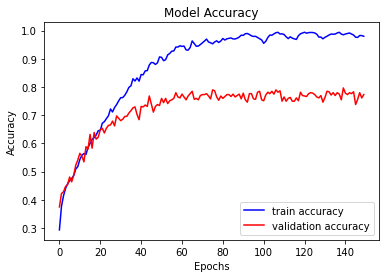

In [26]:
#plotting history of model 7
plt.plot(history7.history['accuracy'], c='b', label='train accuracy')
plt.plot(history7.history['val_accuracy'], c='r', label='validation accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

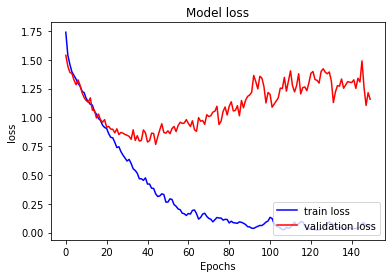

In [27]:
# plot training & validation loss values
plt.plot(history7.history['loss'], c='b', label='train loss')
plt.plot(history7.history['val_loss'], c='r', label='validation loss')
plt.legend(loc='lower right')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

In [28]:
!pip install mlxtend

In [29]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, classification_report


In [30]:
y_pred=model7.predict(X_test)

y_true= np.argmax(y_test, axis=1).tolist()
y_pred =np.argmax(y_pred, axis=1).tolist()
multilabel_confusion_matrix(y_true, y_pred)

array([[[860,  30],
        [ 36, 124]],

       [[831,  56],
        [ 37, 126]],

       [[882,  30],
        [ 35, 103]],

       [[871,  31],
        [ 61,  87]],

       [[866,  44],
        [ 38, 102]],

       [[870,  24],
        [ 36, 120]],

       [[834,  71],
        [ 43, 102]]], dtype=int64)

In [31]:
accuracy= accuracy_score(y_true, y_pred)
print("Accuracy Score: {:.2f}%".format(accuracy*100))
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


Accuracy Score: 72.76%
[[124   8   0  15   1   1  11]
 [  9 126   1   4   4   3  16]
 [  0   4 103   4  12   6   9]
 [ 13  16   1  87   3   3  25]
 [  1   5  15   1 102   8   8]
 [  1  15   8   1   9 120   2]
 [  6   8   5   6  15   3 102]]
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       160
           1       0.69      0.77      0.73       163
           2       0.77      0.75      0.76       138
           3       0.74      0.59      0.65       148
           4       0.70      0.73      0.71       140
           5       0.83      0.77      0.80       156
           6       0.59      0.70      0.64       145

    accuracy                           0.73      1050
   macro avg       0.73      0.73      0.73      1050
weighted avg       0.73      0.73      0.73      1050



(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

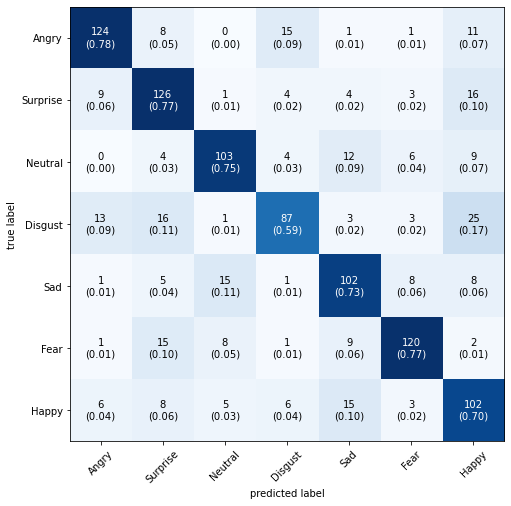

In [32]:
class_names=['Angry', 'Surprise', 'Neutral', 'Disgust', 'Sad', 'Fear', 'Happy']
mat = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(8,8), class_names=class_names, show_normed=True)

In [33]:
test_loss, test_acc=model7.evaluate(X_test, y_test)
print("\n Test Acc: ", test_acc)
print("\n Test Loss: ", test_loss)

33/33 [==============================] - 1s 36ms/step - loss: 1.5363 - accuracy: 0.7276

 Test Acc:  0.7276190519332886

 Test Loss:  1.5363106727600098


In [34]:
model7.save("Bengali_Speech_Emotion_Recognition_Model_SUBESCO.h5")

# Second for 75 Features


In [20]:
## Training the Model
history7= model7.fit(X_train, y_train, epochs=150, batch_size= 256, validation_split=0.1,
               	shuffle=True, callbacks=[mc])

#Bismillah :/

Epoch 1/150
21/21 [==============================] - 20s 798ms/step - loss: 1.8148 - accuracy: 0.2633 - val_loss: 1.5190 - val_accuracy: 0.3866

Epoch 00001: val_accuracy improved from -inf to 0.38655, saving model to .\model.h5
Epoch 2/150
21/21 [==============================] - 18s 860ms/step - loss: 1.5522 - accuracy: 0.3500 - val_loss: 1.4180 - val_accuracy: 0.4555

Epoch 00002: val_accuracy improved from 0.38655 to 0.45546, saving model to .\model.h5
Epoch 3/150
21/21 [==============================] - 24s 1s/step - loss: 1.4456 - accuracy: 0.4169 - val_loss: 1.3533 - val_accuracy: 0.4504

Epoch 00003: val_accuracy did not improve from 0.45546
Epoch 4/150
21/21 [==============================] - 26s 1s/step - loss: 1.3758 - accuracy: 0.4416 - val_loss: 1.2880 - val_accuracy: 0.4924

Epoch 00004: val_accuracy improved from 0.45546 to 0.49244, saving model to .\model.h5
Epoch 5/150
21/21 [==============================] - 26s 1s/step - loss: 1.3186 - accuracy: 0.4675 - val_loss: 1.

21/21 [==============================] - 25s 1s/step - loss: 0.3184 - accuracy: 0.8857 - val_loss: 0.6445 - val_accuracy: 0.8050

Epoch 00039: val_accuracy did not improve from 0.81681
Epoch 40/150
21/21 [==============================] - 25s 1s/step - loss: 0.3043 - accuracy: 0.8919 - val_loss: 0.5495 - val_accuracy: 0.8067

Epoch 00040: val_accuracy did not improve from 0.81681
Epoch 41/150
21/21 [==============================] - 25s 1s/step - loss: 0.2663 - accuracy: 0.9052 - val_loss: 0.5549 - val_accuracy: 0.8336

Epoch 00041: val_accuracy improved from 0.81681 to 0.83361, saving model to .\model.h5
Epoch 42/150
21/21 [==============================] - 25s 1s/step - loss: 0.2407 - accuracy: 0.9123 - val_loss: 0.5530 - val_accuracy: 0.8420

Epoch 00042: val_accuracy improved from 0.83361 to 0.84202, saving model to .\model.h5
Epoch 43/150
21/21 [==============================] - 25s 1s/step - loss: 0.2064 - accuracy: 0.9303 - val_loss: 0.6534 - val_accuracy: 0.8134

Epoch 00043: v


Epoch 00079: val_accuracy did not improve from 0.86387
Epoch 80/150
21/21 [==============================] - 25s 1s/step - loss: 0.0737 - accuracy: 0.9761 - val_loss: 0.6878 - val_accuracy: 0.8588

Epoch 00080: val_accuracy did not improve from 0.86387
Epoch 81/150
21/21 [==============================] - 25s 1s/step - loss: 0.0580 - accuracy: 0.9812 - val_loss: 0.7089 - val_accuracy: 0.8538

Epoch 00081: val_accuracy did not improve from 0.86387
Epoch 82/150
21/21 [==============================] - 25s 1s/step - loss: 0.0446 - accuracy: 0.9881 - val_loss: 0.6935 - val_accuracy: 0.8487

Epoch 00082: val_accuracy did not improve from 0.86387
Epoch 83/150
21/21 [==============================] - 25s 1s/step - loss: 0.0456 - accuracy: 0.9873 - val_loss: 0.7511 - val_accuracy: 0.8303

Epoch 00083: val_accuracy did not improve from 0.86387
Epoch 84/150
21/21 [==============================] - 25s 1s/step - loss: 0.0693 - accuracy: 0.9766 - val_loss: 0.7388 - val_accuracy: 0.8286

Epoch 000

21/21 [==============================] - 26s 1s/step - loss: 0.0188 - accuracy: 0.9947 - val_loss: 0.6093 - val_accuracy: 0.8773

Epoch 00121: val_accuracy improved from 0.86387 to 0.87731, saving model to .\model.h5
Epoch 122/150
21/21 [==============================] - 26s 1s/step - loss: 0.0171 - accuracy: 0.9937 - val_loss: 0.6546 - val_accuracy: 0.8706

Epoch 00122: val_accuracy did not improve from 0.87731
Epoch 123/150
21/21 [==============================] - 26s 1s/step - loss: 0.0133 - accuracy: 0.9957 - val_loss: 0.6813 - val_accuracy: 0.8655

Epoch 00123: val_accuracy did not improve from 0.87731
Epoch 124/150
21/21 [==============================] - 27s 1s/step - loss: 0.0177 - accuracy: 0.9960 - val_loss: 0.7739 - val_accuracy: 0.8605

Epoch 00124: val_accuracy did not improve from 0.87731
Epoch 125/150
21/21 [==============================] - 28s 1s/step - loss: 0.0181 - accuracy: 0.9935 - val_loss: 0.8861 - val_accuracy: 0.8454

Epoch 00125: val_accuracy did not improve 

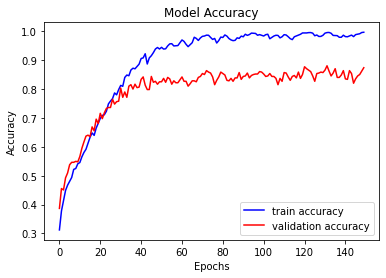

In [21]:
 #plotting history of model 7
plt.plot(history7.history['accuracy'], c='b', label='train accuracy')
plt.plot(history7.history['val_accuracy'], c='r', label='validation accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

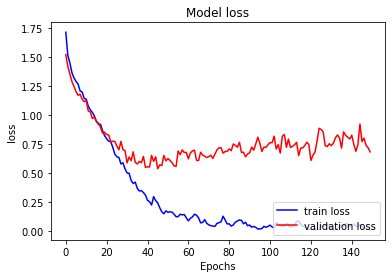

In [22]:
# plot training & validation loss values
plt.plot(history7.history['loss'], c='b', label='train loss')
plt.plot(history7.history['val_loss'], c='r', label='validation loss')
plt.legend(loc='lower right')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

In [23]:
!pip install mlxtend

In [24]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, classification_report

In [25]:
y_pred=model7.predict(X_test)

y_true= np.argmax(y_test, axis=1).tolist()
y_pred =np.argmax(y_pred, axis=1).tolist()
multilabel_confusion_matrix(y_true, y_pred)

array([[[870,  20],
        [ 17, 143]],

       [[867,  20],
        [ 38, 125]],

       [[887,  25],
        [ 11, 127]],

       [[852,  50],
        [ 22, 126]],

       [[892,  18],
        [ 32, 108]],

       [[881,  13],
        [ 21, 135]],

       [[876,  29],
        [ 34, 111]]], dtype=int64)

In [26]:
accuracy= accuracy_score(y_true, y_pred)
print("Accuracy Score: {:.2f}%".format(accuracy*100))
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy Score: 83.33%
[[143   1   0  14   0   0   2]
 [  6 125   4  11   3   3  11]
 [  2   0 127   6   2   0   1]
 [  6   5   1 126   1   2   7]
 [  1   1  17   2 108   6   5]
 [  0   9   1   3   5 135   3]
 [  5   4   2  14   7   2 111]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       160
           1       0.86      0.77      0.81       163
           2       0.84      0.92      0.88       138
           3       0.72      0.85      0.78       148
           4       0.86      0.77      0.81       140
           5       0.91      0.87      0.89       156
           6       0.79      0.77      0.78       145

    accuracy                           0.83      1050
   macro avg       0.84      0.83      0.83      1050
weighted avg       0.84      0.83      0.83      1050



(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

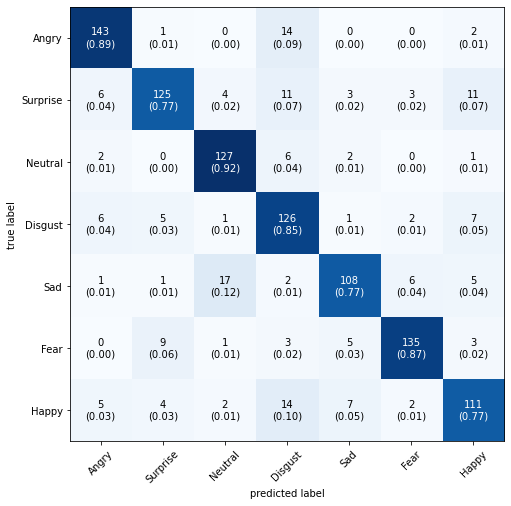

In [27]:
class_names=['Angry', 'Surprise', 'Neutral', 'Disgust', 'Sad', 'Fear', 'Happy']
mat = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(8,8), class_names=class_names, show_normed=True)